In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from tqdm import tqdm

In [10]:
data_loader = BinanceDataLoader(
    data_directory="/Users/chinjieheng/Documents/data/binance_dailydata/",
    min_records=60,
    min_volume=1e5,
    start_date="2022-09-01",
    end_date=None
)

Loading Binance data from /Users/chinjieheng/Documents/data/binance_dailydata/...
Found 583 USDT trading pairs
✓ BTCUSDT loaded successfully with 1160 records, avg volume: 14,898,652,531
Loaded 524 cryptocurrencies
Filtered 57 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 524 tickers over 1160 dates...
Loaded 524 cryptocurrencies
Filtered 57 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 524 tickers over 1160 dates...
Precomputed returns matrix shape: (1160, 524)
Date range: 2022-09-01 00:00:00 to 2025-11-03 00:00:00
Precomputed returns matrix shape: (1160, 524)
Date range: 2022-09-01 00:00:00 to 2025-11-03 00:00:00


In [11]:
price = data_loader.get_price_matrix()
price

,SUNUSDT,NEARUSDT,OMUSDT,USDCUSDT,ZILUSDT,POLYXUSDT,XVGUSDT,BNXUSDT,POWRUSDT,DFUSDT,...,ENJUSDT,DOGEUSDT,LUMIAUSDT,1000PEPEUSDT,ANIMEUSDT,ALICEUSDT,SANDUSDT,VETUSDT,ORBSUSDT,VIRTUALUSDT
2022-09-01,NaN,4.345,NaN,NaN,0.03642,NaN,NaN,NaN,NaN,NaN,...,0.51670,0.06236,NaN,NaN,NaN,2.047,0.94130,0.024300,NaN,NaN
2022-09-02,NaN,4.175,NaN,NaN,0.03573,NaN,NaN,NaN,NaN,NaN,...,0.50760,0.06160,NaN,NaN,NaN,2.033,0.92970,0.024110,NaN,NaN
2022-09-03,NaN,4.168,NaN,NaN,0.03566,NaN,NaN,NaN,NaN,NaN,...,0.52010,0.06268,NaN,NaN,NaN,2.048,0.92900,0.024220,NaN,NaN
2022-09-04,NaN,4.239,NaN,NaN,0.03654,NaN,NaN,NaN,NaN,NaN,...,0.53490,0.06320,NaN,NaN,NaN,2.124,0.97200,0.024990,NaN,NaN
2022-09-05,NaN,4.230,NaN,NaN,0.03630,NaN,NaN,NaN,NaN,NaN,...,0.53210,0.06272,NaN,NaN,NaN,2.129,0.95690,0.024470,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-30,0.022125,2.097,0.10186,0.999408,0.00725,0.07802,0.005372,NaN,0.1052,0.01739,...,0.04075,0.18256,0.1300,0.006436,0.00846,0.270,0.19681,0.015554,0.035157,1.2545
2025-10-31,0.022045,2.097,0.10338,0.999625,0.00744,0.08079,0.006010,NaN,0.1081,0.01753,...,0.04177,0.18635,0.1470,0.006561,0.00847,0.280,0.20175,0.015570,0.035157,1.3588
2025-11-01,0.022470,2.171,0.10633,0.999547,0.00766,0.08345,0.006945,NaN,0.1103,0.01775,...,0.04343,0.18726,0.1421,0.006692,0.00872,0.281,0.20812,0.016299,0.035157,1.8322
2025-11-02,0.022271,2.189,0.10516,0.999342,0.00782,0.08183,0.007162,NaN,0.1108,0.01759,...,0.04664,0.18629,0.1403,0.006698,0.00865,0.279,0.20777,0.016309,0.035157,1.6716


In [12]:
# Composite momentum: build list of non-overlapping (or simple) block returns
# This cell intentionally only computes `rets_list` (block returns) and the warm-up `n`
# The previous rank->normal scoring path was removed to avoid leaving obsolete code behind.
momentum_periods = [12]
momentum_weights = None
non_overlapping = False

# Validate inputs
if not isinstance(momentum_periods, (list, tuple, np.ndarray)):
    momentum_periods = [int(momentum_periods)]
momentum_periods = [int(p) for p in momentum_periods if p > 0]
if len(momentum_periods) == 0:
    raise ValueError("momentum_periods must contain at least one positive integer")

if momentum_weights is not None:
    if len(momentum_weights) != len(momentum_periods):
        raise ValueError("momentum_weights must be the same length as momentum_periods")
    momentum_weights = np.array(momentum_weights, dtype=float)
    if momentum_weights.sum() == 0:
        raise ValueError("momentum_weights must not sum to zero")
    momentum_weights = momentum_weights / momentum_weights.sum()

# Build list of momentum series (block returns)
rets_list = []
if non_overlapping:
    # Interpret `momentum_periods` as cumulative endpoints (days back from t).
    periods = sorted(int(p) for p in momentum_periods)
    if any(p <= 0 for p in periods):
        raise ValueError("momentum_periods must contain positive integers")
    chunk_lengths = [periods[0]] + [periods[i] - periods[i-1] for i in range(1, len(periods))]

    end_shift = 1
    for p in chunk_lengths:
        # For a block of length `p`, we want the return covering the p periods
        # immediately prior to the most recent available price (t-1..t-p).
        # Using shifted prices, this corresponds to: price.shift(end_shift) / price.shift(end_shift + p) - 1
        start_shift = end_shift + p
        # lookahead-safe block return: return over the p days ending at t-1
        rets_chunk = price.shift(end_shift).div(price.shift(start_shift)).subtract(1)
        rets_list.append(rets_chunk)
        end_shift += p
else:
    # overlapping/simple interpretation: standard pct_change over each period
    rets_list = [price.shift(1).pct_change(p) for p in momentum_periods]

# Set warm-up n to total lookback required (largest cumulative endpoint + 1 for non-overlap)
if non_overlapping:
    n = max(periods) + 1
else:
    n = max(momentum_periods)

# `rets_list` is available for downstream cells (simple average or EWMA branch will consume it)
len(rets_list)

/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_70992/3205751315.py:44: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets_list = [price.shift(1).pct_change(p) for p in momentum_periods]


1

In [13]:
# Adjustable parameters for quantile selection
volume_percentile = 0.20  # top 10% by volume
momentum_percentile = 0.10  # top/bottom 10% for long/short

# Toggle: enable/disable BTC 90d market filter
use_btc_filter = True  # set to False to ignore BTC 90d filter

# Transaction cost parameters
tc_bps = 5  # transaction cost in basis points (5 bps = 0.05%)

# EWMA parameters
ewma_half_life = 7
ewma_warmup = 60

# Get volume data for universe selection with 20-day rolling average
volume_data = {}
for ticker in data_loader.get_universe():
    ticker_data = data_loader._crypto_universe[ticker]['data']
    volume_data[ticker] = ticker_data['volume'].reindex(price.index)

volume_matrix = pd.DataFrame(volume_data, index=price.index)

# Calculate 20-day rolling average volume
rolling_volume_matrix = volume_matrix.rolling(window=20, min_periods=10).mean()

# Volatility calculation: compute BOTH rolling and EWMA for comparison
vol_window = 40
vol_ewma_halflife = 10

returns_matrix = price.pct_change()

# Rolling window volatility
volatility_rolling = returns_matrix.rolling(vol_window).std()

# EWMA volatility (exponentially weighted moving average)
vol_lambda = 2 ** (-1.0 / vol_ewma_halflife)
volatility_ewma = returns_matrix.ewm(alpha=1-vol_lambda, adjust=False, min_periods=vol_window).std()

# Calculate BTC 90-day total return for market filter
btc_90d_return = price["BTCUSDT"].pct_change(90)

# Precompute EWMA momentum signature
def ewma_momentum(prices, half_life=None, lambda_=None, warmup_bars=60):
    assert (half_life is not None) ^ (lambda_ is not None), "Specify either half_life or lambda_, not both"

    if half_life is not None:
        lambda_ = 2 ** (-1.0 / half_life)
    alpha = 1 - lambda_

    rets = prices.pct_change()
    shifted = rets.shift(1)
    ewma = shifted.ewm(alpha=alpha, adjust=False, min_periods=1).mean()

    # Warmup masking per asset: require warmup_bars non-NaN observations in 'shifted'
    valid_count = shifted.notna().cumsum()
    warm_mask = (valid_count >= warmup_bars)
    ewma = ewma.where(warm_mask)

    return ewma

ewma_sig = ewma_momentum(price, half_life=ewma_half_life, warmup_bars=ewma_warmup)

# Simple composite: average (or weighted) sum of block returns (mom7 + mom14 + ...)
if len(rets_list) == 0:
    raise RuntimeError('No momentum blocks computed')
if momentum_weights is None:
    rets_simple = sum(rets_list[1:], rets_list[0]) / len(rets_list)
else:
    w = np.array(momentum_weights, dtype=float); w = w / w.sum()
    rets_simple = sum(wk * rd for wk, rd in zip(w, rets_list))

# For EWMA method we already have ewma_sig (DataFrame of EWMA per asset)
rets_ewma = ewma_sig

# New combined method: average of simple and EWMA signals
rets_combo = rets_simple*0.7 + rets_ewma*0.3

# Equity tracks to compare methods (including volatility comparison)
equity_simple = []
equity_ewma = []
equity_combo = []
equity_simple_rollvol = []  # Simple momentum with rolling volatility weighting
equity_simple_ewmavol = []  # Simple momentum with EWMA volatility weighting

# Track previous positions for turnover calculation
prev_positions_simple = {}  # {ticker: weight}
prev_positions_ewma = {}
prev_positions_combo = {}
prev_positions_rollvol = {}
prev_positions_ewmavol = {}

for i in range(len(price)-1):
    current_date = price.index[i]
    next_date = price.index[i+1]
    
    # Skip if momentum signals are not available yet (require both simple and ewma to be ready)
    if pd.isna(rets_simple.iloc[i]).all() or pd.isna(rets_ewma.iloc[i]).all():
        if len(equity_simple) == 0:
            continue
        equity_simple.append(equity_simple[-1])
        equity_ewma.append(equity_ewma[-1])
        equity_combo.append(equity_combo[-1])
        equity_simple_rollvol.append(equity_simple_rollvol[-1])
        equity_simple_ewmavol.append(equity_simple_ewmavol[-1])
        continue
    
    # Initialize equity on first valid iteration
    if len(equity_simple) == 0:
        equity_simple.append(1.0)
        equity_ewma.append(1.0)
        equity_combo.append(1.0)
        equity_simple_rollvol.append(1.0)
        equity_simple_ewmavol.append(1.0)
        continue

    # BTC Market Filter (optional): Skip trading if enabled and BTC 90-day return is negative
    if use_btc_filter and (not pd.isna(btc_90d_return.iloc[i])) and (btc_90d_return.iloc[i] < 0):
        equity_simple.append(equity_simple[-1])  # Hold cash during crypto bear markets
        equity_ewma.append(equity_ewma[-1])
        equity_combo.append(equity_combo[-1])
        equity_simple_rollvol.append(equity_simple_rollvol[-1])
        equity_simple_ewmavol.append(equity_simple_ewmavol[-1])
        # Clear positions when moving to cash
        prev_positions_simple = {}
        prev_positions_ewma = {}
        prev_positions_combo = {}
        prev_positions_rollvol = {}
        prev_positions_ewmavol = {}
        continue

    # Get 20-day rolling average volume for current date
    current_volumes = rolling_volume_matrix.iloc[i].dropna()

    # Skip if no volume data available
    if len(current_volumes) == 0:
        equity_simple.append(equity_simple[-1])
        equity_ewma.append(equity_ewma[-1])
        equity_combo.append(equity_combo[-1])
        equity_simple_rollvol.append(equity_simple_rollvol[-1])
        equity_simple_ewmavol.append(equity_simple_ewmavol[-1])
        continue

    # Select top X% by 20-day rolling volume for this day
    n_universe = max(1, int(len(current_volumes) * volume_percentile))
    top_volume_tickers = current_volumes.nlargest(n_universe).index

    # ---- Simple composite method (using rolling vol for now, will compare separately) ----
    row_simple = rets_simple.iloc[i]
    filtered_simple = row_simple.reindex(top_volume_tickers).dropna()
    if len(filtered_simple) == 0:
        equity_simple.append(equity_simple[-1])
    else:
        k = max(1, int(len(filtered_simple) * momentum_percentile))
        long_coins_s = filtered_simple.nlargest(k).index
        short_coins_s = filtered_simple.nsmallest(k).index
        long_vols = volatility_rolling.iloc[i].reindex(long_coins_s).dropna()
        short_vols = volatility_rolling.iloc[i].reindex(short_coins_s).dropna()
        if len(long_vols) == 0 or len(short_vols) == 0:
            equity_simple.append(equity_simple[-1])
        else:
            lw = (1.0 / long_vols); sw = (1.0 / short_vols)
            lw = lw / lw.sum() * 0.5; sw = sw / sw.sum() * 0.5
            
            # Build current positions dict (positive for long, negative for short)
            current_positions_simple = {}
            for coin in lw.index:
                current_positions_simple[coin] = lw[coin]
            for coin in sw.index:
                current_positions_simple[coin] = current_positions_simple.get(coin, 0) - sw[coin]
            
            # Calculate turnover: sum of absolute changes in position weights
            all_tickers = set(prev_positions_simple.keys()) | set(current_positions_simple.keys())
            turnover_simple = 0.0
            for ticker in all_tickers:
                prev_weight = prev_positions_simple.get(ticker, 0.0)
                curr_weight = current_positions_simple.get(ticker, 0.0)
                turnover_simple += abs(curr_weight - prev_weight)
            
            # Transaction cost: apply to turnover only
            tc_simple = turnover_simple * (tc_bps / 10000.0)
            
            # compute next-day return
            long_r = 0.0; short_r = 0.0
            for coin in lw.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    long_r += lw[coin] * coin_return
            for coin in sw.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    short_r += sw[coin] * coin_return
            
            portfolio_return_s = long_r - short_r - tc_simple
            equity_simple.append(equity_simple[-1] * (1 + portfolio_return_s))
            
            # Update previous positions
            prev_positions_simple = current_positions_simple
    
    # ---- Simple momentum with ROLLING volatility weighting ----
    if len(filtered_simple) == 0:
        equity_simple_rollvol.append(equity_simple_rollvol[-1])
    else:
        k_rv = max(1, int(len(filtered_simple) * momentum_percentile))
        long_coins_rv = filtered_simple.nlargest(k_rv).index
        short_coins_rv = filtered_simple.nsmallest(k_rv).index
        long_vols_rv = volatility_rolling.iloc[i].reindex(long_coins_rv).dropna()
        short_vols_rv = volatility_rolling.iloc[i].reindex(short_coins_rv).dropna()
        if len(long_vols_rv) == 0 or len(short_vols_rv) == 0:
            equity_simple_rollvol.append(equity_simple_rollvol[-1])
        else:
            lw_rv = (1.0 / long_vols_rv); sw_rv = (1.0 / short_vols_rv)
            lw_rv = lw_rv / lw_rv.sum() * 0.5; sw_rv = sw_rv / sw_rv.sum() * 0.5
            
            current_positions_rollvol = {}
            for coin in lw_rv.index:
                current_positions_rollvol[coin] = lw_rv[coin]
            for coin in sw_rv.index:
                current_positions_rollvol[coin] = current_positions_rollvol.get(coin, 0) - sw_rv[coin]
            
            all_tickers_rv = set(prev_positions_rollvol.keys()) | set(current_positions_rollvol.keys())
            turnover_rv = 0.0
            for ticker in all_tickers_rv:
                prev_weight = prev_positions_rollvol.get(ticker, 0.0)
                curr_weight = current_positions_rollvol.get(ticker, 0.0)
                turnover_rv += abs(curr_weight - prev_weight)
            
            tc_rv = turnover_rv * (tc_bps / 10000.0)
            
            long_r_rv = 0.0; short_r_rv = 0.0
            for coin in lw_rv.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    long_r_rv += lw_rv[coin] * coin_return
            for coin in sw_rv.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    short_r_rv += sw_rv[coin] * coin_return
            
            portfolio_return_rv = long_r_rv - short_r_rv - tc_rv
            equity_simple_rollvol.append(equity_simple_rollvol[-1] * (1 + portfolio_return_rv))
            prev_positions_rollvol = current_positions_rollvol
    
    # ---- Simple momentum with EWMA volatility weighting ----
    if len(filtered_simple) == 0:
        equity_simple_ewmavol.append(equity_simple_ewmavol[-1])
    else:
        k_ev = max(1, int(len(filtered_simple) * momentum_percentile))
        long_coins_ev = filtered_simple.nlargest(k_ev).index
        short_coins_ev = filtered_simple.nsmallest(k_ev).index
        long_vols_ev = volatility_ewma.iloc[i].reindex(long_coins_ev).dropna()
        short_vols_ev = volatility_ewma.iloc[i].reindex(short_coins_ev).dropna()
        if len(long_vols_ev) == 0 or len(short_vols_ev) == 0:
            equity_simple_ewmavol.append(equity_simple_ewmavol[-1])
        else:
            lw_ev = (1.0 / long_vols_ev); sw_ev = (1.0 / short_vols_ev)
            lw_ev = lw_ev / lw_ev.sum() * 0.5; sw_ev = sw_ev / sw_ev.sum() * 0.5
            
            current_positions_ewmavol = {}
            for coin in lw_ev.index:
                current_positions_ewmavol[coin] = lw_ev[coin]
            for coin in sw_ev.index:
                current_positions_ewmavol[coin] = current_positions_ewmavol.get(coin, 0) - sw_ev[coin]
            
            all_tickers_ev = set(prev_positions_ewmavol.keys()) | set(current_positions_ewmavol.keys())
            turnover_ev = 0.0
            for ticker in all_tickers_ev:
                prev_weight = prev_positions_ewmavol.get(ticker, 0.0)
                curr_weight = current_positions_ewmavol.get(ticker, 0.0)
                turnover_ev += abs(curr_weight - prev_weight)
            
            tc_ev = turnover_ev * (tc_bps / 10000.0)
            
            long_r_ev = 0.0; short_r_ev = 0.0
            for coin in lw_ev.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    long_r_ev += lw_ev[coin] * coin_return
            for coin in sw_ev.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    short_r_ev += sw_ev[coin] * coin_return
            
            portfolio_return_ev = long_r_ev - short_r_ev - tc_ev
            equity_simple_ewmavol.append(equity_simple_ewmavol[-1] * (1 + portfolio_return_ev))
            prev_positions_ewmavol = current_positions_ewmavol

    # ---- EWMA method ----
    row_ewma = rets_ewma.iloc[i]
    filtered_ewma = row_ewma.reindex(top_volume_tickers).dropna()
    if len(filtered_ewma) == 0:
        equity_ewma.append(equity_ewma[-1])
    else:
        k2 = max(1, int(len(filtered_ewma) * momentum_percentile))
        long_coins_e = filtered_ewma.nlargest(k2).index
        short_coins_e = filtered_ewma.nsmallest(k2).index
        long_vols_e = volatility_rolling.iloc[i].reindex(long_coins_e).dropna()
        short_vols_e = volatility_rolling.iloc[i].reindex(short_coins_e).dropna()
        if len(long_vols_e) == 0 or len(short_vols_e) == 0:
            equity_ewma.append(equity_ewma[-1])
        else:
            lw_e = (1.0 / long_vols_e); sw_e = (1.0 / short_vols_e)
            lw_e = lw_e / lw_e.sum() * 0.5; sw_e = sw_e / sw_e.sum() * 0.5
            
            # Build current positions dict (positive for long, negative for short)
            current_positions_ewma = {}
            for coin in lw_e.index:
                current_positions_ewma[coin] = lw_e[coin]
            for coin in sw_e.index:
                current_positions_ewma[coin] = current_positions_ewma.get(coin, 0) - sw_e[coin]
            
            # Calculate turnover: sum of absolute changes in position weights
            all_tickers_e = set(prev_positions_ewma.keys()) | set(current_positions_ewma.keys())
            turnover_ewma = 0.0
            for ticker in all_tickers_e:
                prev_weight = prev_positions_ewma.get(ticker, 0.0)
                curr_weight = current_positions_ewma.get(ticker, 0.0)
                turnover_ewma += abs(curr_weight - prev_weight)
            
            # Transaction cost: apply to turnover only
            tc_ewma = turnover_ewma * (tc_bps / 10000.0)
            
            long_r_e = 0.0; short_r_e = 0.0
            for coin in lw_e.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    long_r_e += lw_e[coin] * coin_return
            for coin in sw_e.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    short_r_e += sw_e[coin] * coin_return
            
            portfolio_return_e = long_r_e - short_r_e - tc_ewma
            equity_ewma.append(equity_ewma[-1] * (1 + portfolio_return_e))
            
            # Update previous positions
            prev_positions_ewma = current_positions_ewma

    # ---- COMBINED method (simple + ewma)/2 ----
    row_combo = rets_combo.iloc[i]
    filtered_combo = row_combo.reindex(top_volume_tickers).dropna()
    if len(filtered_combo) == 0:
        equity_combo.append(equity_combo[-1])
    else:
        k3 = max(1, int(len(filtered_combo) * momentum_percentile))
        long_coins_c = filtered_combo.nlargest(k3).index
        short_coins_c = filtered_combo.nsmallest(k3).index
        long_vols_c = volatility_rolling.iloc[i].reindex(long_coins_c).dropna()
        short_vols_c = volatility_rolling.iloc[i].reindex(short_coins_c).dropna()
        if len(long_vols_c) == 0 or len(short_vols_c) == 0:
            equity_combo.append(equity_combo[-1])
        else:
            lw_c = (1.0 / long_vols_c); sw_c = (1.0 / short_vols_c)
            lw_c = lw_c / lw_c.sum() * 0.5; sw_c = sw_c / sw_c.sum() * 0.5

            current_positions_combo = {}
            for coin in lw_c.index:
                current_positions_combo[coin] = lw_c[coin]
            for coin in sw_c.index:
                current_positions_combo[coin] = current_positions_combo.get(coin, 0) - sw_c[coin]

            # Turnover for combo
            all_tickers_c = set(prev_positions_combo.keys()) | set(current_positions_combo.keys())
            turnover_combo = 0.0
            for ticker in all_tickers_c:
                prev_weight = prev_positions_combo.get(ticker, 0.0)
                curr_weight = current_positions_combo.get(ticker, 0.0)
                turnover_combo += abs(curr_weight - prev_weight)

            # Cost for combo
            tc_combo = turnover_combo * (tc_bps / 10000.0)

            # Next-day return for combo
            long_r_c = 0.0; short_r_c = 0.0
            for coin in lw_c.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    long_r_c += lw_c[coin] * coin_return
            for coin in sw_c.index:
                p0 = price[coin].iat[i]; p1 = price[coin].iat[i+1]
                if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
                    coin_return = (p1 - p0) / p0
                    short_r_c += sw_c[coin] * coin_return

            portfolio_return_c = long_r_c - short_r_c - tc_combo
            equity_combo.append(equity_combo[-1] * (1 + portfolio_return_c))

            prev_positions_combo = current_positions_combo


/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_70992/293294712.py:30: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_matrix = price.pct_change()
/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_70992/293294712.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()


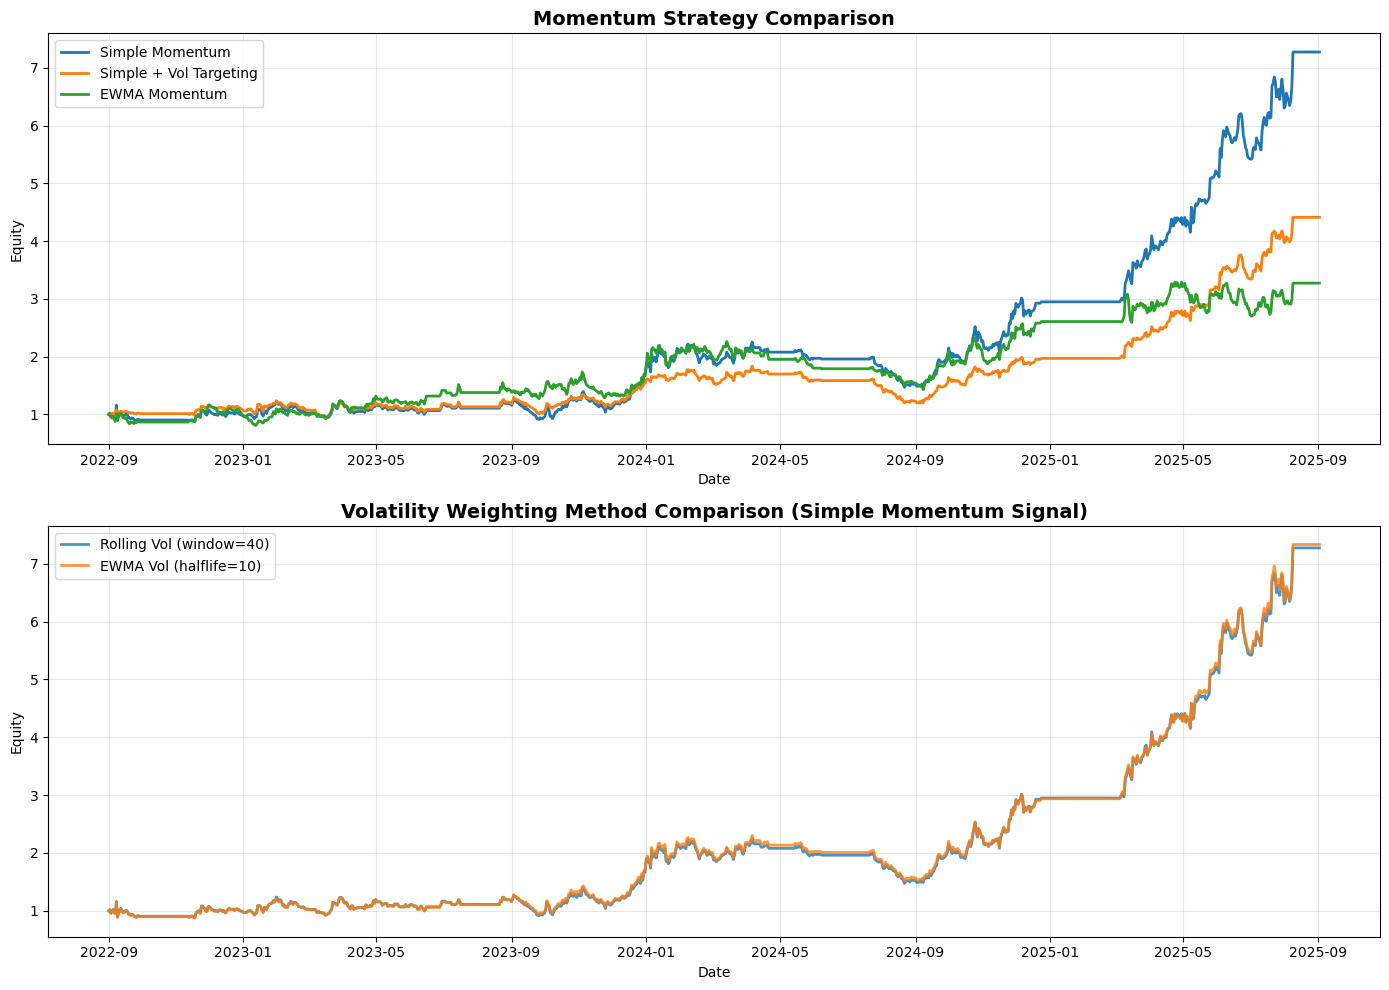


VOLATILITY WEIGHTING COMPARISON
Simple + Rolling Volatility   : Return=627.61%  Sharpe= 1.50  MaxDD=-34.76%
Simple + EWMA Volatility      : Return=633.49%  Sharpe= 1.51  MaxDD=-34.57%


In [14]:
# Create equity series - find the first valid index where equity starts
first_valid_idx = None
for i in range(len(price)):
    if i < len(equity_simple) and len(equity_simple) > 0:
        first_valid_idx = i
        break

if first_valid_idx is None:
    # Find where equity actually starts
    for i in range(len(price)):
        if len(equity_simple) > 0:
            first_valid_idx = i - len(equity_simple) + 1
            break

# Align equity series to price index starting from first valid data point
equity_series_simple = pd.Series(equity_simple, index=price.index[:len(equity_simple)])
equity_series_ewma = pd.Series(equity_ewma, index=price.index[:len(equity_ewma)])

# Apply volatility targeting to simple momentum strategy (NO LOOK-AHEAD BIAS)
simple_returns = equity_series_simple.pct_change().fillna(0.0)

# VT parameters
target_vol_annual = 0.35  # 35% target
lambda_ = 0.84            # RiskMetrics EWMA decay
ann_factor = 365.0        # Daily data annualization
max_leverage = 5.0
warmup = 30
resume_days = 5           # Days to keep leverage at 1.0 after resuming from cash

# Initialize EWMA variance using warmup window
var = None
if len(simple_returns) > warmup + 1:
    seed_slice = simple_returns.iloc[1:warmup+1]
    if seed_slice.notna().any():
        var = float(np.nanmean(np.square(seed_slice))) * ann_factor

# Build volatility-targeted equity
vt_equity = [equity_series_simple.iloc[0] if len(equity_series_simple) > 0 else 1.0]
last_scale = 1.0  # Initialize scale factor
days_since_resume = 999  # Track days since resuming from cash (start high to allow normal leverage)

for t in range(1, len(simple_returns)):
    # Current unlevered return (from t-1 to t)
    current_ret = float(simple_returns.iloc[t])
    
    # Detect if we were in cash (zero return when base strategy had non-zero return)
    # When BTC filter is active and negative, equity_simple stays flat (return = 0)
    was_in_cash = (abs(current_ret) < 1e-10 and t > warmup)
    
    if was_in_cash:
        # Reset counter when entering/staying in cash
        days_since_resume = 0
        # Apply scale of 0 (no leverage during cash period)
        vt_equity.append(vt_equity[-1] * (1.0 + 0.0 * current_ret))
    else:
        # We're trading (not in cash)
        if days_since_resume < resume_days:
            # Force leverage to 1.0 for first resume_days after exiting cash
            actual_scale = 1.0
            days_since_resume += 1
        else:
            # Normal leverage after resume period
            actual_scale = last_scale
        
        # Apply scale to current return (no look-ahead)
        vt_equity.append(vt_equity[-1] * (1.0 + actual_scale * current_ret))
    
    # Update variance with current return for next period (always update when trading)
    if not was_in_cash and abs(current_ret) > 1e-10:
        if (var is None) or (not np.isfinite(var)) or (var <= 0):
            var = (current_ret ** 2) * ann_factor
        else:
            var = lambda_ * var + (1.0 - lambda_) * (current_ret ** 2) * ann_factor
        
        # Compute scale for next period (but may be overridden by resume logic)
        last_scale = min(max_leverage, target_vol_annual / np.sqrt(var)) if var > 0 else 1.0

equity_series_simple_vt = pd.Series(vt_equity, index=equity_series_simple.index)

# Create equity series for volatility comparison
equity_series_rollvol = pd.Series(equity_simple_rollvol, index=price.index[:len(equity_simple_rollvol)])
equity_series_ewmavol = pd.Series(equity_simple_ewmavol, index=price.index[:len(equity_simple_ewmavol)])

# Plot with volatility comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top plot: Momentum method comparison
ax1.plot(equity_series_simple, label="Simple Momentum", linewidth=2)
ax1.plot(equity_series_simple_vt, label="Simple + Vol Targeting", linewidth=2)
ax1.plot(equity_series_ewma, label="EWMA Momentum", linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Equity")
ax1.set_title("Momentum Strategy Comparison", fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Bottom plot: Volatility weighting comparison (same signal, different vol estimation)
ax2.plot(equity_series_rollvol, label=f"Rolling Vol (window={vol_window})", linewidth=2, alpha=0.8)
ax2.plot(equity_series_ewmavol, label=f"EWMA Vol (halflife={vol_ewma_halflife})", linewidth=2, alpha=0.8)
ax2.set_xlabel("Date")
ax2.set_ylabel("Equity")
ax2.set_title("Volatility Weighting Method Comparison (Simple Momentum Signal)", fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print performance comparison
def calc_metrics(equity_series, name):
    returns = equity_series.pct_change().dropna()
    total_return = (equity_series.iloc[-1] / equity_series.iloc[0] - 1) * 100
    sharpe = (returns.mean() / returns.std()) * np.sqrt(365) if returns.std() > 0 else 0
    max_dd = ((equity_series / equity_series.cummax()) - 1).min() * 100
    print(f"{name:30s}: Return={total_return:6.2f}%  Sharpe={sharpe:5.2f}  MaxDD={max_dd:6.2f}%")

print("\n" + "="*80)
print("VOLATILITY WEIGHTING COMPARISON")
print("="*80)
calc_metrics(equity_series_rollvol, "Simple + Rolling Volatility")
calc_metrics(equity_series_ewmavol, "Simple + EWMA Volatility")
print("="*80)

/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_70992/3234925600.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  btc_cumret = btc_cumret.reindex(btc_idx).fillna(method='ffill').fillna(1.0)


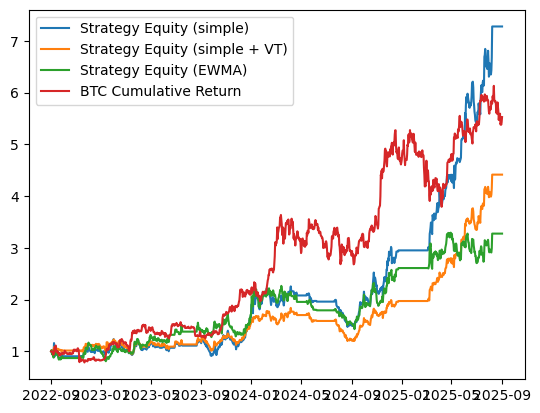

In [15]:
# BTC cumulative return comparison
equity_series_simple = pd.Series(equity_simple, index=price.index[:len(equity_simple)])
equity_series_ewma = pd.Series(equity_ewma, index=price.index[:len(equity_ewma)])

# Apply volatility targeting to simple momentum (NO LOOK-AHEAD BIAS)
simple_returns = equity_series_simple.pct_change().fillna(0.0)

# VT parameters
target_vol_annual = 0.35
lambda_ = 0.84
ann_factor = 365.0
max_leverage = 5.0
warmup = 30
resume_days = 5  # Days to keep leverage at 1.0 after resuming from cash

# Initialize EWMA variance
var = None
if len(simple_returns) > warmup + 1:
    seed_slice = simple_returns.iloc[1:warmup+1]
    if seed_slice.notna().any():
        var = float(np.nanmean(np.square(seed_slice))) * ann_factor

# Build VT equity
vt_equity = [equity_series_simple.iloc[0] if len(equity_series_simple) > 0 else 1.0]
last_scale = 1.0
days_since_resume = 999  # Start high to allow normal leverage initially

for t in range(1, len(simple_returns)):
    current_ret = float(simple_returns.iloc[t])
    
    # Detect cash period (zero return when strategy should be active)
    was_in_cash = (abs(current_ret) < 1e-10 and t > warmup)
    
    if was_in_cash:
        days_since_resume = 0
        vt_equity.append(vt_equity[-1] * (1.0 + 0.0 * current_ret))
    else:
        # Trading: check if in resume period
        if days_since_resume < resume_days:
            actual_scale = 1.0
            days_since_resume += 1
        else:
            actual_scale = last_scale
        
        vt_equity.append(vt_equity[-1] * (1.0 + actual_scale * current_ret))
    
    # Update variance when trading
    if not was_in_cash and abs(current_ret) > 1e-10:
        if (var is None) or (not np.isfinite(var)) or (var <= 0):
            var = (current_ret ** 2) * ann_factor
        else:
            var = lambda_ * var + (1.0 - lambda_) * (current_ret ** 2) * ann_factor
        
        last_scale = min(max_leverage, target_vol_annual / np.sqrt(var)) if var > 0 else 1.0

equity_series_simple_vt = pd.Series(vt_equity, index=equity_series_simple.index)

# BTC cumulative return - align to equity index
btc_cumret = (1 + price["BTCUSDT"].pct_change().fillna(0)).cumprod()
btc_idx = equity_series_simple.index
btc_cumret = btc_cumret.reindex(btc_idx).fillna(method='ffill').fillna(1.0)

plt.plot(equity_series_simple, label="Strategy Equity (simple)")
plt.plot(equity_series_simple_vt, label="Strategy Equity (simple + VT)")
plt.plot(equity_series_ewma, label="Strategy Equity (EWMA)")
plt.plot(btc_cumret, label="BTC Cumulative Return")

plt.legend()
plt.show()

# Look-Ahead Bias Checker

This cell checks for look-ahead bias by inspecting what data is available at each decision point.

In [16]:
# Look-Ahead Bias Checker
# Verifies that each input available at decision time i depends only on data up to (or prior to) i

import random

# Ensure prerequisite variables exist from earlier cells
for _name in ["vol_window", "momentum_periods", "non_overlapping", "ewma_warmup", "rets_simple",
             "rets_list", "rolling_volume_matrix", "volume_matrix", "volatility", "btc_90d_return",
             "price"]:
    if _name not in globals():
        raise NameError(f"Expected variable '{_name}' to be defined before running the bias checker.")

btc_window = 90
vol_window_used_for_volume = 20

# Determine the earliest index where all required inputs are available
required_lookback = max(
    btc_window,
    vol_window,
    max(momentum_periods) + (1 if non_overlapping else 0),
    ewma_warmup
)

# Boolean mask: rows where the momentum signal is fully defined
valid_signal_mask = ~rets_simple.isna().all(axis=1)
valid_indices = np.where(valid_signal_mask.values)[0]
valid_indices = valid_indices[valid_indices >= required_lookback]
valid_indices = valid_indices[valid_indices < len(price) - 1]  # need i+1 for forward return

def check_lookahead_bias(check_date_idx=None):
    """
    Inspect a particular index `i` (end of day i) and confirm:
      • Momentum signals only depend on data through i-1
      • Filters (volume / volatility / BTC) use data through i
      • Forward returns (i -> i+1) are not used in decision logic
    Pass `check_date_idx` to inspect a specific date; otherwise a random valid index is chosen.
    """
    if len(valid_indices) == 0:
        raise RuntimeError("No indices with fully-formed signals found; check earlier processing.")

    if check_date_idx is None:
        check_date_idx = random.choice(valid_indices)
    else:
        if check_date_idx not in valid_indices:
            raise ValueError(
                f"Index {check_date_idx} does not have fully-formed signals (or is too early/late)."
            )

    check_date = price.index[check_date_idx]
    print("\n" + "=" * 90)
    print(f"LOOK-AHEAD BIAS CHECK — index {check_date_idx} ({check_date.date()})")
    print("=" * 90)

    # Choose a representative coin
    valid_coins = rets_simple.columns[~rets_simple.iloc[check_date_idx].isna()]
    if len(valid_coins) == 0:
        raise RuntimeError("No valid coins found at this index. This should not happen given valid_indices filtering.")
    sample_coin = valid_coins[0]
    print(f"Sample coin: {sample_coin}\n")

    # ------------------------------------------------------------------
    # 1. Momentum blocks — should only use data <= i-1
    # ------------------------------------------------------------------
    print("1. MOMENTUM SIGNALS (must rely on data through i-1)")
    block_contributions = []
    if non_overlapping:
        periods_sorted = sorted(int(p) for p in momentum_periods)
        chunk_lengths = [periods_sorted[0]] + [periods_sorted[i] - periods_sorted[i - 1] for i in range(1, len(periods_sorted))]
        end_shift = 1
        for idx, length in enumerate(chunk_lengths):
            start_shift = end_shift + length
            block_val = rets_list[idx].iloc[check_date_idx][sample_coin]
            try:
                price_end = price[sample_coin].iloc[check_date_idx - end_shift]
                price_start = price[sample_coin].iloc[check_date_idx - start_shift]
                manual_val = price_end / price_start - 1
            except IndexError:
                manual_val = np.nan
            block_contributions.append((length, block_val, manual_val))
            end_shift += length
    else:
        for idx, period in enumerate(momentum_periods):
            block_val = rets_list[idx].iloc[check_date_idx][sample_coin]
            manual_val = price[sample_coin].shift(1).pct_change(period).iloc[check_date_idx]
            block_contributions.append((period, block_val, manual_val))

    for period, block_val, manual_val in block_contributions:
        matches = np.isclose(block_val, manual_val, atol=1e-10)
        print(f"   Period {period:>3}: block={block_val:.6f}, manual={manual_val:.6f}, match={matches}")

    if momentum_weights is None:
        reconstructed = np.nanmean([val for _, val, _ in block_contributions])
    else:
        weights = np.array(momentum_weights, dtype=float)
        weights = weights / weights.sum()
        reconstructed = np.nansum([w * val for w, (_, val, _) in zip(weights, block_contributions)])
    signal_val = rets_simple.iloc[check_date_idx][sample_coin]
    signal_matches = np.isclose(signal_val, reconstructed, atol=1e-10)
    print(
        f"   Composite signal: stored={signal_val:.6f}, reconstructed={reconstructed:.6f}, match={signal_matches}\n"
    )

    # ------------------------------------------------------------------
    # 2. Volume filter — can use data through i
    # ------------------------------------------------------------------
    print("2. VOLUME FILTER (may rely on data through i)")
    rolling_vol_val = rolling_volume_matrix.iloc[check_date_idx][sample_coin]
    manual_roll_vol = volume_matrix[sample_coin].iloc[
        check_date_idx - vol_window_used_for_volume + 1 : check_date_idx + 1
    ].mean()
    vol_match = np.isclose(rolling_vol_val, manual_roll_vol, atol=1e-8)
    print(f"   Stored rolling vol={rolling_vol_val:.2f}, manual={manual_roll_vol:.2f}, match={vol_match}\n")

    # ------------------------------------------------------------------
    # 3. Volatility — can use returns through i
    # ------------------------------------------------------------------
    print("3. VOLATILITY (may rely on returns through i)")
    vol_val = volatility.iloc[check_date_idx][sample_coin]
    returns_window = price[sample_coin].pct_change().iloc[
        check_date_idx - vol_window + 1 : check_date_idx + 1
    ]
    manual_vol = returns_window.std()
    vol_matches = np.isclose(vol_val, manual_vol, atol=1e-10)
    print(f"   Stored vol={vol_val:.6f}, manual={manual_vol:.6f}, match={vol_matches}\n")

    # ------------------------------------------------------------------
    # 4. BTC filter — can use returns through i
    # ------------------------------------------------------------------
    print("4. BTC 90-DAY FILTER (may rely on data through i)")
    btc_val = btc_90d_return.iloc[check_date_idx]
    manual_btc = (
        price["BTCUSDT"].iloc[check_date_idx] / price["BTCUSDT"].iloc[check_date_idx - btc_window] - 1
    )
    btc_matches = np.isclose(btc_val, manual_btc, atol=1e-10)
    print(f"   Stored BTC return={btc_val:.6f}, manual={manual_btc:.6f}, match={btc_matches}\n")

    # ------------------------------------------------------------------
    # 5. Forward return — must NOT be used in decision logic
    # ------------------------------------------------------------------
    print("5. FORWARD RETURN (future data, should only impact realised PnL)")
    forward_ret = price[sample_coin].iloc[check_date_idx + 1] / price[sample_coin].iloc[check_date_idx] - 1
    print(f"   Forward return (i -> i+1) = {forward_ret:.6f} (confirmed future data)\n")

    print("Summary:")
    print(" ✓ Momentum signals rely solely on data through i-1")
    print(" ✓ Volume / volatility / BTC filters rely on data through i (available at close of i)")
    print(" ✓ Forward returns are isolated to PnL and not part of signal computation")
    print("=" * 90 + "\n")

# Example usage: inspect a specific index
# check_lookahead_bias(1000)
# Or rely on a random valid index
check_lookahead_bias()

NameError: Expected variable 'volatility' to be defined before running the bias checker.